In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import time

In [2]:
train_data = torchvision.datasets.CIFAR10('.', train = True, transform = transforms.ToTensor(), download = True)
test_data = torchvision.datasets.CIFAR10('.', train = False, transform = transforms.ToTensor(), download = True)


batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# images are in the shape of 32x32x3 (HxWxC) | C: color channels
train_data.data.shape

(50000, 32, 32, 3)

In [4]:
# we have K=10 classes
K = len(train_data.classes)

In [5]:
# class distribution
class_count = []
for c in range(len(train_data.classes)):
  count = (np.array(train_data.targets) == c).sum()
  class_count.append(count)

px.bar(x=train_data.classes, y = class_count)

In [6]:
# create model for the class
class CNN_v1(nn.Module):
  def __init__(self, K):
    super(CNN_v1, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2) # 32x32x(3) -> 15x15x(3)x32
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2) # 15x15x(3)x32 -> 7x7x(3)x64
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2) # 7x7x(3)x64 ->  3x3x(3)x128

    self.fc1 = nn.Linear(3*3*128,1024)
    self.fc2 = nn.Linear(1024, K)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(-1, 128 * 3 * 3) # flatten the image 
    x = F.dropout(x, p = .5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p = .2)
    x = self.fc2(x)
    return x

In [7]:
# initalize the model
cnn_model = CNN_v1(K)

# initialize the criterion and the optimizer instances
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters())

In [8]:
# pick a device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('selected %s ' % device)
# pass the model to selected device
cnn_model.to(device)

selected cuda:0 


CNN_v1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [9]:
# define prediction and training functions
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  """
  Apply batch gradient descent to given model and data.
  Data must be DataLoader object
  """
  
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    t0 = time.time()
    train_loss = []
    test_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      # we don't need to flatten the input since
      # we use CNN's as first layers of our NN

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      # backward propagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # keep the loss
      train_loss.append(loss.item())

    # calculate the loss for training too
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    
    # get the average loss for both train and test sets and keep them too
    avg_train_loss = np.mean(train_loss)
    avg_test_loss = np.mean(test_loss)
    train_losses[i] = avg_train_loss
    test_losses[i] = avg_test_loss

    # calculate the time
    t1 = time.time()

    print("-"*50)
    print(f"Epoch {i+1}/{epochs} took {t1-t0:.3f}s \n avg_loss for train: {avg_train_loss:.4f} \n avg_loss for test: {avg_test_loss:.4f}")
    print("-"*50)

  return train_loss, test_loss

def validation_predict(model, data_loader, acc=True):
  """
  Make predictions with given DataLoader object. 
  Return the predictions and accuracy(if acc=True) 
  """
  n_correct = 0
  n_total = 0
  predictions = np.array([])
  with torch.no_grad():
    for inputs, targets in data_loader:
      # we're getting logits from model, so applying
      # softmax would be enough

      # pass the data to gpu
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)

      # return the index that has maximum value of a column
      # this is almost same as applying softmax itself in our situation
      _, preds = torch.max(outputs, 1)
      if acc:
        accuracy = (preds == targets).sum().item()
        n_correct += accuracy
        n_total += (targets.shape[0])
      predictions = np.concatenate((predictions, preds.cpu().numpy()))

  return [predictions,(n_correct/n_total)] if acc else predictions

In [10]:
n_epochs = 20
train_loss, test_loss = batch_gd(cnn_model, criterion, optimizer, train_loader, test_loader, n_epochs)

--------------------------------------------------
Epoch 1/20 took 13.678s 
 avg_loss for train: 1.6971 
 avg_loss for test: 1.4798
--------------------------------------------------
--------------------------------------------------
Epoch 2/20 took 13.682s 
 avg_loss for train: 1.4135 
 avg_loss for test: 1.3449
--------------------------------------------------
--------------------------------------------------
Epoch 3/20 took 13.584s 
 avg_loss for train: 1.3011 
 avg_loss for test: 1.2662
--------------------------------------------------
--------------------------------------------------
Epoch 4/20 took 13.328s 
 avg_loss for train: 1.2132 
 avg_loss for test: 1.2073
--------------------------------------------------
--------------------------------------------------
Epoch 5/20 took 13.441s 
 avg_loss for train: 1.1414 
 avg_loss for test: 1.1549
--------------------------------------------------
--------------------------------------------------
Epoch 6/20 took 13.235s 
 avg_loss

In [11]:
# calculate the accuracy for train and test sets
_, train_accuracy = validation_predict(cnn_model, train_loader)
test_preds, test_accuracy = validation_predict(cnn_model, test_loader)
print(f"Train accuracy: {train_accuracy:.4f} | Test accuracy: {test_accuracy:.4f} ")

Train accuracy: 0.7780 | Test accuracy: 0.6523 


In [12]:
# now plot the losses again with plotly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,n_epochs+1)), y=train_loss, name='Train loss', mode = 'lines+markers'))
fig.add_trace(go.Scatter(x=list(range(1,n_epochs+1)), y=test_loss, name='Test loss', mode = 'lines+markers'))
fig.show()

In [13]:
test_preds = test_preds.astype(np.uint8)
test_inputs = test_data.data
test_targets = np.array(test_data.targets)
misclassified_idx = np.where(test_preds != test_targets)[0]
print(f"Total misclassified image count is {len(misclassified_idx)}")
print(f"{(len(misclassified_idx)/test_targets.shape[0]) * 100:.2f}% of the images are misclassified by the model.")

Total misclassified image count is 3477
34.77% of the images are misclassified by the model.


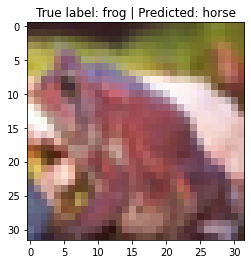

In [14]:
# plot a random example
r = np.random.choice(misclassified_idx)
plt.imshow(test_inputs[r].reshape(32,32,3), cmap = 'gray')
plt.title(f"True label: {test_data.classes[test_targets[r]]} | Predicted: {test_data.classes[test_preds[r]]}")
plt.show()